In [1]:
%load_ext cudf.pandas

# Basic Computation

In this lesson, we discuss how to do scientific computations with xarray
objects. Our learning goals are as follows. By the end of the lesson, we will be
able to:

- Apply basic arithmetic and numpy functions to xarray DataArrays / Dataset.
- Use Xarray's label-aware reduction operations (e.g. `mean`, `sum`) weighted
  reductions.
- Apply arbitrary functions to Xarray data via `apply_ufunc`.
- Use Xarray's broadcasting to compute on arrays of different dimensionality.

In [2]:
%%cudf.pandas.profile

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Ask Xarray to not show data values by default
xr.set_options(display_expand_data=False)

%config InlineBackend.figure_format='retina'

                                                                                              
                                  Total time elapsed: 1.561 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncei.noaa.gov/products/extended-reconstructed-sst)
product, a widely used and trusted gridded compilation of of historical data going back to 1854.

In [3]:
%%cudf.pandas.profile

ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

                                                                                                               
                                           Total time elapsed: 4.029 seconds                                   
                                        303 GPU function calls in 0.135 seconds                                
                                        18 CPU function calls in 0.013 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ isna                      │ 0          │ 0.000       │ 0.000       │ 10         │ 0.006       │ 0.001       │
│ to_timedelta              │ 0          │ 0.000       │ 0.000       │ 6          │ 0.005       │ 0.001       │
│ ndarray.reshape           │ 0          │ 0.000       │ 0.000       │ 2          │ 0.001       │ 0.001       │
│ Index                     │ 3          │ 0.008       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 178        │ 0.056       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__  │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 89         │ 0.029       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__ │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.014       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna
- to_timedelta
- ndarray.reshape

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=200983;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

Let's do some basic visualizations of the data, just to make sure it looks
reasonable.


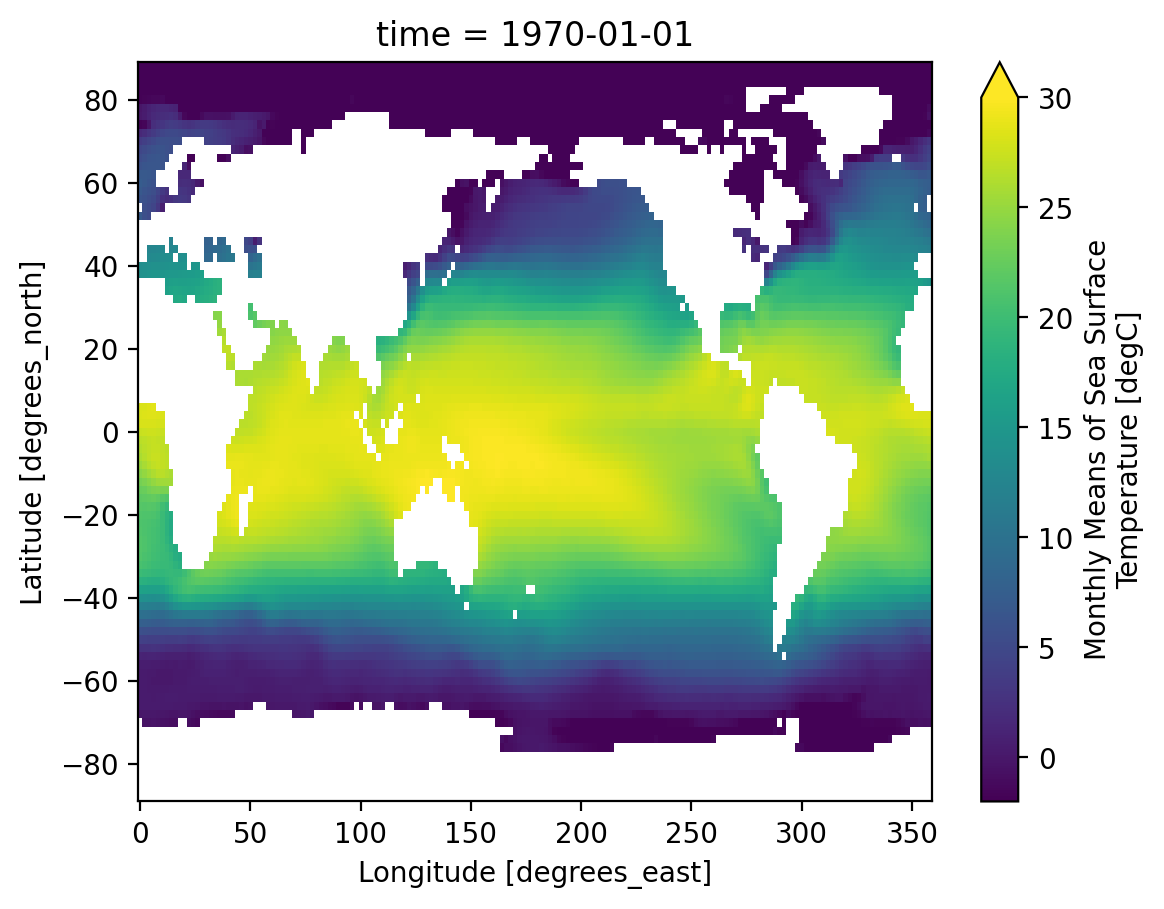

                                                                                                               
                                           Total time elapsed: 1.774 seconds                                   
                                        32 GPU function calls in 0.014 seconds                                 
                                         1 CPU function calls in 0.001 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 2          │ 0.004       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 26         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ isna                      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=168915;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [4]:
%%cudf.pandas.profile

ds.sst.isel(time=0).plot(vmin=-2, vmax=30);

## Arithmetic

Xarray dataarrays and datasets work seamlessly with arithmetic operators and
numpy array functions.

For example, imagine we want to convert the temperature (given in Celsius) to
Kelvin:


In [5]:
%%cudf.pandas.profile

sst_kelvin = ds.sst + 273.15
sst_kelvin

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
271.4 271.4 271.4 271.4 271.4 271.4 271.4 271.4 ... nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

                                                                                                               
                                           Total time elapsed: 0.393 seconds                                   
                                        234 GPU function calls in 0.105 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 142        │ 0.045       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 71         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.013       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

The dimensions and coordinates were preserved following the operation.

<div class="alert alert-warning">
    <strong>Warning:</strong> Although many xarray datasets have a <code>units</code> attribute, which is used in plotting,
    Xarray does not inherently understand units. However, xarray can integrate with <a href="https://pint.readthedocs.io/en/0.12/">pint</a>, which provides full unit-aware operations. See <a href="https://pint-xarray.readthedocs.io">pint-xarray</a> for more.
</div>


## Applying functions

We can apply more complex functions to Xarray objects.
Imagine we wanted to compute the following expression as a function of SST
($\Theta$) in Kelvin:

$$ f(\Theta) =  0.5 \ln(\Theta^2) $$


In [6]:
%%cudf.pandas.profile

f = 0.5 * np.log(sst_kelvin**2)
f

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
5.603 5.603 5.603 5.603 5.603 5.603 5.603 5.603 ... nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

                                                                                                               
                                           Total time elapsed: 0.396 seconds                                   
                                        234 GPU function calls in 0.097 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 142        │ 0.042       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 71         │ 0.021       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.011       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

## Applying Arbitrary Functions

It's awesome that we can call `np.log(ds)` and have it "just work". However, not
all third party libraries work this way.

numpy's [nan_to_num](https://numpy.org/devdocs/reference/generated/numpy.nan_to_num.html) for example will return a numpy array

In [7]:
%%cudf.pandas.profile

np.nan_to_num(ds.sst, 0)

array([[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       ...,

       [[-1.8, -1.8, -1.

                                                                                              
                                  Total time elapsed: 0.103 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

It would be nice to keep our dimensions and coordinates. 

We can accomplish this with [xr.apply_ufunc](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html#xarray.apply_ufunc)

In [8]:
%%cudf.pandas.profile

xr.apply_ufunc(np.nan_to_num, ds.sst, 0)

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
-1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

                                                                                                               
                                           Total time elapsed: 0.382 seconds                                   
                                        249 GPU function calls in 0.102 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 150        │ 0.045       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 75         │ 0.022       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.011       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{tip}
`apply_ufunc` is a powerful function. It has many options for doing more complicated things. Unfortunately, we don't have time to go into more depth here. See the [`apply_ufunc` tutorial material](https://tutorial.xarray.dev/advanced/apply_ufunc/apply_ufunc.html) for more.
```


## Reductions

Reductions are functions that reduce the dimensionlity of our dataset. For example taking the mean sea surface temperature along `time` of our 3D data, we "reduce" the  `time` dimension and are left with a 2D array.

Just like in numpy, we can reduce xarray DataArrays along any number of axes.

In [9]:
%%cudf.pandas.profile

sst = ds.sst
sst.mean(axis=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
-1.799 -1.799 -1.799 -1.799 -1.799 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

                                                                                                              
                                          Total time elapsed: 0.273 seconds                                   
                                       156 GPU function calls in 0.067 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__     │ 142        │ 0.045       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__ │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__    │ 2          │ 0.012       │ 0.006       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

However, rather than performing reductions by specifying `axis` (as in numpy), we can instead perform
them using _dimension names_. This turns out to be a huge convenience, particularly in
complex calculations it can be hard to remember which axis corresponds to 
which dimension name:

In [10]:
%%cudf.pandas.profile

sst.mean(dim="time")

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
-1.799 -1.799 -1.799 -1.799 -1.799 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

                                                                                                              
                                          Total time elapsed: 0.271 seconds                                   
                                       156 GPU function calls in 0.065 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__     │ 142        │ 0.044       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__ │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__    │ 2          │ 0.012       │ 0.006       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

You can reduce over multiple dimensions

In [11]:
%%cudf.pandas.profile

sst.mean(["lat", "time"])

<xarray.DataArray 'sst' (lon: 180)>
7.692 7.824 8.239 8.131 7.586 7.546 ... 9.776 9.419 8.303 7.818 7.842 7.641
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

                                                                                                              
                                          Total time elapsed: 0.200 seconds                                   
                                        81 GPU function calls in 0.033 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__     │ 74         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__    │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

If no dimension is specified, the reduction is applied across all dimensions.

In [12]:
%%cudf.pandas.profile

sst.mean()

<xarray.DataArray 'sst' ()>
9.473

                                                                                              
                                  Total time elapsed: 0.090 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

All of the standard numpy reductions (e.g. `min`, `max`, `sum`, `std`, etc.) are
available on both [Datasets](https://docs.xarray.dev/en/stable/api.html#aggregation) and [DataArrays](https://docs.xarray.dev/en/stable/api.html#id6).


```{exercise}
:label: sst-mean
Take the mean of `sst` in both longitude and latitude. Make a simple timeseries plot.
```
````{solution} sst-mean
:class: dropdown

sst.mean(["lat", "lon"]).plot();
```
